# **Deep Learning Methods for Facial Emotion Recognition**

# **Transfer Learning using the ResNet101 model**
----

# **Brief Overview**

This notebook is a continuation of the main Capstone project that included "attenuated transfer learning" that ended with suboptimal results.

By **attenuation** I mean that only the final convolutional block of each pretrained models was used.

The table below illustrates the performance of the three types of pretrained models with this attenuated method.

<br>

------------

<br>

The pretrained model discussed in this notebook is the ResNet101 model. The convolutional (feature extraction) layers form the first part of this transfer learning model. The classification (fully connected) portion of the model is of my own construction.

<br>

-----------

<br>

## **FER 2013 Dataset**

**3 sets of data that each contain 4 classes (happy, sad, neutral, surprise)**
- **Training** set has 15,109 images
- **Validation** set has 4,977 images
- **Testing** set has 128 images

<br>

------------

<br>

## **Part 1: Frozen ResNet101**

- The **feature extraction (ResNet101)** portion is **FROZEN** - hyperparameters are as provided from the TensorFlow Keras environment.

- The **classification (fully connected) is unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

------------

<br>


## **Part 2: UN-Frozen ResNet101**

- The **feature extraction (ResNet101)** portion is **UN-FROZEN** - hyperparameters are allowed to change as the model is trained on the FER2013 dataset.

- The **classification (fully connected) remains unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

-----------

## **Final data table with attenuated pretrained models, compared against custom made CNN models of my design**

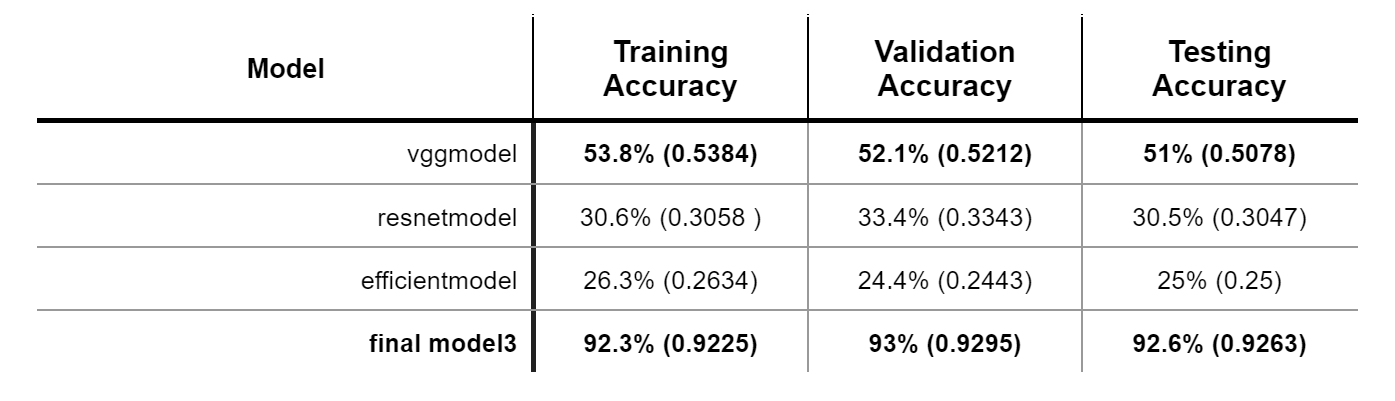

----
## **The table below shows performance data for the frozen models and the unfrozen models.**

- The **un-frozen VGG16** model demonstrated the greatest performance improvement
- The **EfficientNet** model remains unoptimized. That work is shown in another notebook in this Capstone folder.

<br>

------  

<br>

## **Key code changes to perform the analysis shown in this notebook include:**

- ResNet101 expects an input shape of (224, 224, 3) while the FER 2013 dataset is 48 x 48. The data loader code resizes the FER 2013 images to 224 x 224

- 

## **Mounting the Drive**

**NOTE:** It is recommended that you use Google Colab with the GPU option selected to open and run the code in this notebook. 

In [1]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing relevant libraries**

In [2]:
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import tensorflow as tf
import keras

# Importing Deep Learning Libraries

import tensorflow.keras.applications as ap

from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPool2D, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


In [3]:
# Clearing backend
from tensorflow.keras import backend

backend.clear_session()

# Fixing the seed for random number generators
import random

np.random.seed(42)

random.seed(42)

tf.random.set_seed(42)

### **Load the data**
A subset of the (Facial Emotion Recognition) FER 2013 which includes only these emotion classes: happy, sad, neutral, surprise

In [4]:
# Path of the data file from the Google drive

path = '/content/drive/MyDrive/Data_Science_Class/CAPSTONE_Project/CAP_proj_facial_emot_det/First-draft-w-GL-notebooks/Facial_emotion_images.zip'

# Data is provided as a zip file. The following extracts these files

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

In [5]:
picture_size = 48
folder_path = "Facial_emotion_images/"

## **ResNet 101 Model**

ResNet101 is a convolutional neural network that is:
- 101 layers deep
- is pretrained on more than a million images from the ImageNet database
- can classify images into 1000 object categories
- has learned rich feature representations for a wide range of images
- Source: https://www.mathworks.com/help/deeplearning/ref/resnet101.html

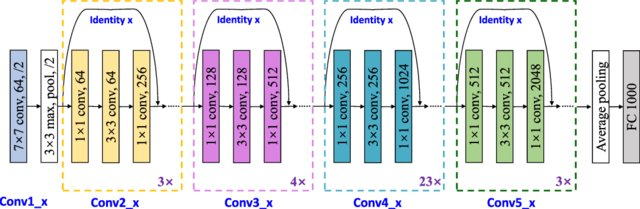

## **Importing the ResNet101 Architecture**

In [6]:
# 'include_top = False' is set this way to preserve the stability provided by unchanging parameters in the Batch Normalization' layers during the UNFROZEN section in Part 2, below.

Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(224,224,3))
Resnet.summary()

171446536/171446536 [==============================] - 7s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                       

### **Data Loaders for data augmentation and preparation for use in the Transfer Learning Architectures**

# **Base dataloader**

In [7]:
batch_size  = 32

# ResNet101 expects an input_shape of 224, 224, 3
# If the model is set to False re: trainable then it can handle other shapes. If it is set to True then it MUST be set to 224, 224, 3
# https://keras.io/api/applications/resnet/#resnet101-function

img_size = 224

datagen_train = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

train_set = datagen_train.flow_from_directory(folder_path + "train",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_validation = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

validation_set = datagen_validation.flow_from_directory(folder_path + "validation",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

datagen_test = ImageDataGenerator(horizontal_flip = True,
                                    brightness_range = (0., 2.),
                                    rescale = 1./255,
                                    shear_range = 0.3)

test_set = datagen_test.flow_from_directory(folder_path + "test",
                                              target_size = (img_size, img_size),
                                              color_mode = 'rgb',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              classes = ['happy', 'sad', 'neutral', 'surprise'],
                                              shuffle = True)

Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


------------

<br>

## **Part 1: Frozen ResNet101**

- The **feature extraction (ResNet101)** portion is **FROZEN** - hyperparameters are as provided from the TensorFlow Keras environment.

- The **classification (fully connected) is unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

------------

In [8]:
# The frozen ResNet101 model is set to False so that new values are not learned in the feature extraction portion

Resnet.trainable=False

# Flattening the output from the Resnet101 model
x = Flatten()(Resnet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

# Initializing the model
frozen_resnetmodel = Model(Resnet.input, pred) 

## **Visualizing the FROZEN ResNet101, as created above.**

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.861564 to fit



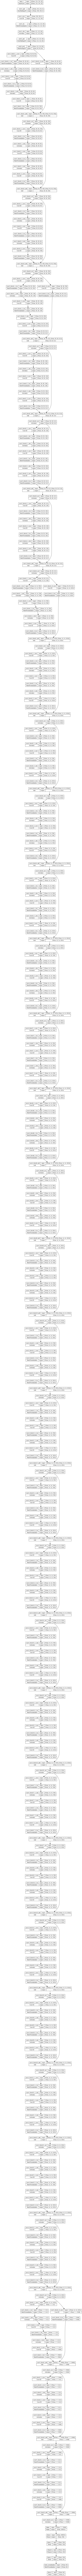

In [9]:
img_file = './resnetmodel_frozen.png'

tf.keras.utils.plot_model(frozen_resnetmodel, to_file=img_file, show_shapes=True, show_layer_names=True)

## **Setting up checkpoints**

In [10]:

r101_frozen_checkpoint = ModelCheckpoint("./Resnetmodel_frozen.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')


early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True
                               ) 


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001) 


callbacks_list = [early_stopping, r101_frozen_checkpoint, reduce_learningrate]

epochs = 20

### **Compiling and Training the FROZEN ResNet101 Model**

In [11]:
# Compiling the FROZEN ResNet101model using categorical crossentropy as your loss function, Adamax Optimizer with 0.001 learning rate and metrics set to 'accuracy'. 

frozen_resnetmodel.compile(loss = 'categorical_crossentropy',
                    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.001),
                    metrics = ['accuracy'])


In [12]:
# Fitting the FROZEN ResNet101 model using train_set as the training data and validation_set as the validation data, for 20 epochs.

history_resnetmodel_frozen = frozen_resnetmodel.fit(train_set,
                          validation_data = validation_set,
                          epochs = 20)

Epoch 1/20
473/473 [==============================] - 275s 552ms/step - loss: 1.5513 - accuracy: 0.2496 - val_loss: 1.3866 - val_accuracy: 0.2443
Epoch 2/20
473/473 [==============================] - 260s 549ms/step - loss: 1.4289 - accuracy: 0.2597 - val_loss: 1.3552 - val_accuracy: 0.2459
Epoch 3/20
473/473 [==============================] - 262s 554ms/step - loss: 1.3990 - accuracy: 0.2759 - val_loss: 1.3448 - val_accuracy: 0.3818
Epoch 4/20
473/473 [==============================] - 265s 561ms/step - loss: 1.3780 - accuracy: 0.2913 - val_loss: 1.3179 - val_accuracy: 0.2944
Epoch 5/20
473/473 [==============================] - 260s 549ms/step - loss: 1.3267 - accuracy: 0.3267 - val_loss: 1.2984 - val_accuracy: 0.3024
Epoch 6/20
473/473 [==============================] - 261s 551ms/step - loss: 1.2982 - accuracy: 0.3475 - val_loss: 1.2567 - val_accuracy: 0.3607
Epoch 7/20
473/473 [==============================] - 261s 552ms/step - loss: 1.2694 - accuracy: 0.3822 - val_loss: 1.2407 -

### **Evaluating the FROZEN ResNet101 Model performance on training and validation data**

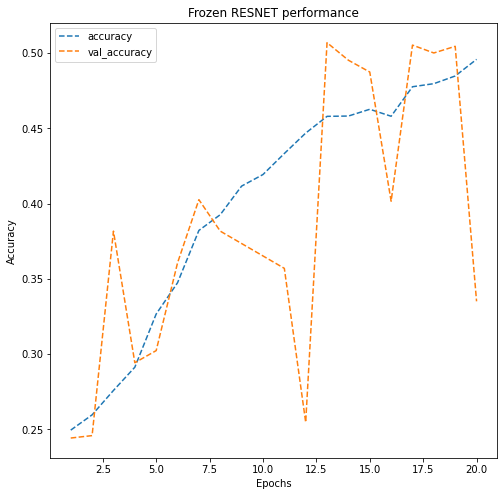

In [13]:
# Plotting the accuracy curves for the training and validation sets of the FROZEN ResNet101 model

dict_hist = history_resnetmodel_frozen.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.title('Frozen RESNET performance')

plt.legend()

plt.show()

### **Evaluating the FROZEN ResNet101 model performance on new TEST data**

In [14]:
# Evaluating the FROZEN ResNet101 model performance on the TEST SET

frozen_resnetmodel.evaluate(test_set)

4/4 [==============================] - 2s 400ms/step - loss: 1.3165 - accuracy: 0.4375


[1.3165178298950195, 0.4375]

------------

<br>


## **Part 2: UN-Frozen ResNet101**

- The **feature extraction (ResNet101)** portion is **UN-FROZEN** - hyperparameters are allowed to change as the model is trained on the FER2013 dataset.

- The **classification (fully connected) remains unfrozen** and will learn new hyperparameter values during training on the FER 2013 dataset.

<br>

-----------

In [15]:
# In this UNFROZEN state, the weights and other parameters in the convolutional layers of the ResNet101 model are allowed to change as the model is run through the FER 2013 training data

Resnet.trainable = True

# Flattening the output from the UN-FROZEN Resnet model
x = Flatten()(Resnet.output)

# Add a Dense layer with 256 neurons
x = Dense(256, activation = 'relu')(x)

# Add a Dense Layer with 128 neurons
x = Dense(128, activation = 'relu')(x)

# Add a DropOut layer with Drop out ratio of 0.3
x = Dropout(0.3)(x)

# Add a Dense Layer with 64 neurons
x = Dense(64, activation = 'relu')(x)

# Add a Batch Normalization layer
x = BatchNormalization()(x)

# Add the final dense layer with 4 neurons and use a 'softmax' activation
pred = Dense(4, activation = 'softmax')(x)

# Initializing the model
UN_resnetmodel = Model(Resnet.input, pred) 

## **Visualizing the ResNet101 model, as created above.**

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.861564 to fit



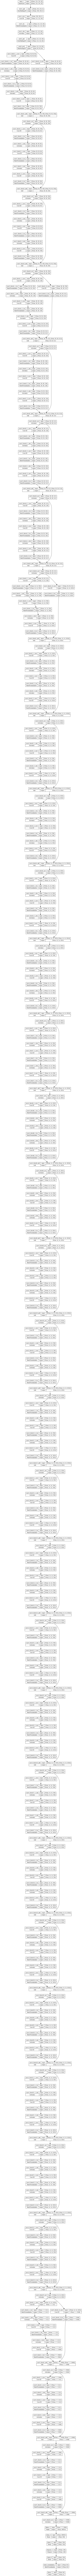

In [16]:
img_file = './resnetmodel_UNfrozen.png'

tf.keras.utils.plot_model(UN_resnetmodel, to_file=img_file, show_shapes=True, show_layer_names=True)

## **Setting up checkpoints**

In [18]:
r101_UN_frozen_checkpoint = ModelCheckpoint("./Resnetmodel_UN_frozen.h5", monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')


early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0,
                               patience = 3,
                               verbose = 1,
                               restore_best_weights = True
                               ) 


reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001) 


callbacks_list = [early_stopping, r101_UN_frozen_checkpoint, reduce_learningrate]

epochs = 20

### **Compiling and Training the UNFROZEN ResNet101 Model**

In [19]:
# Compiling the UN-FROZEN ResNet101 model using categorical crossentropy as your loss function, Adam Optimizer with 1e-05 learning rate and metrics set to 'accuracy'. 

UN_resnetmodel.compile(loss = 'categorical_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-05),
                    metrics = ['accuracy'])


In [20]:
# Fitting the UN-FROZEN ResNet101 model using train_set as the training data and validation_set as the validation data, for 20 epochs.

history_resnetmodel_UNfrozen = UN_resnetmodel.fit(train_set,
                          validation_data = validation_set,
                          epochs = 20)

Epoch 1/20
473/473 [==============================] - 362s 734ms/step - loss: 1.4234 - accuracy: 0.4186 - val_loss: 7.6116 - val_accuracy: 0.3058
Epoch 2/20
473/473 [==============================] - 346s 730ms/step - loss: 1.0494 - accuracy: 0.5726 - val_loss: 1.1062 - val_accuracy: 0.5180
Epoch 3/20
473/473 [==============================] - 344s 727ms/step - loss: 0.9039 - accuracy: 0.6356 - val_loss: 1.0490 - val_accuracy: 0.5696
Epoch 4/20
473/473 [==============================] - 345s 730ms/step - loss: 0.8177 - accuracy: 0.6690 - val_loss: 0.8066 - val_accuracy: 0.6661
Epoch 5/20
473/473 [==============================] - 345s 730ms/step - loss: 0.7512 - accuracy: 0.7001 - val_loss: 0.7078 - val_accuracy: 0.7211
Epoch 6/20
473/473 [==============================] - 345s 729ms/step - loss: 0.7015 - accuracy: 0.7180 - val_loss: 0.6841 - val_accuracy: 0.7342
Epoch 7/20
473/473 [==============================] - 347s 732ms/step - loss: 0.6643 - accuracy: 0.7332 - val_loss: 0.7016 -

### **Evaluating the UN-FROZEN ResNet101 Model performance on training and validation data**

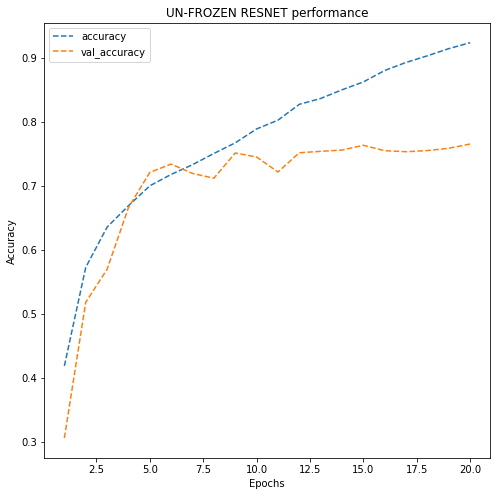

In [21]:
# Plotting the accuracy curves for the training and validation sets of the UN-FROZEN ResNet101 model

dict_hist = history_resnetmodel_UNfrozen.history

list_ep = [i for i in range(1, 21)]

plt.figure(figsize = (8, 8))

plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')

plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')

plt.ylabel('Accuracy')

plt.xlabel('Epochs')

plt.title('UN-FROZEN RESNET performance')

plt.legend()

plt.show()

### **Evaluating the UN-FROZEN ResNet101 Model performance on new TEST data**

In [22]:
# Evaluating the UN-FROZEN ResNet101 model performance on the TEST SET

UN_resnetmodel.evaluate(test_set)

4/4 [==============================] - 2s 398ms/step - loss: 0.5535 - accuracy: 0.7969


[0.5534650087356567, 0.796875]